<a href="https://colab.research.google.com/github/sbarreto10/data-science-2022/blob/main/VALORES%20HUMANOS%20(PROYECTO%20FINAL)/75_06_TP_4_BASELINE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**IMPORTACIONES**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import math
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from math import cos,sin,pi
from tqdm import tqdm
import colorsys
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import Dense, TextVectorization, Lambda, concatenate
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import Callback
from matplotlib import animation
from IPython.core.display import display, HTML

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#**LECTURA**

In [ ]:
args = pd.read_csv("/content/drive/MyDrive/tp4/human-values/arguments-training.tsv", sep="\t")
labels = pd.read_csv("/content/drive/MyDrive/tp4/human-values/labels-training.tsv", sep="\t")
# labels1 = pd.read_csv("/content/drive/MyDrive/tp4/human-values/level1-labels-training.tsv", sep="\t")
# cats = pd.read_json("/content/drive/MyDrive/tp4/human-values/value-categories.json")

#**PREPROCESAMIENTO**

In [ ]:
humanValues = args.merge(labels, how="inner", on="Argument ID")

Text(0.5, 1.0, 'Histograma de cantidad de premisas por conclusión')

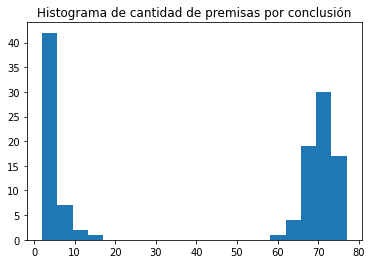

In [ ]:
plt.hist(humanValues.groupby("Conclusion").count().Premise.tolist(), bins=20)
plt.title("Histograma de cantidad de premisas por conclusión")

In [ ]:
humanValues["Stance"] = humanValues["Stance"].map(lambda x: 1 if x=="in favor of" else -1)

In [ ]:
X = humanValues[['Conclusion', 'Stance', 'Premise']]
y = humanValues[['Self-direction: thought', 'Self-direction: action', 'Stimulation',
       'Hedonism', 'Achievement', 'Power: dominance', 'Power: resources',
       'Face', 'Security: personal', 'Security: societal', 'Tradition',
       'Conformity: rules', 'Conformity: interpersonal', 'Humility',
       'Benevolence: caring', 'Benevolence: dependability',
       'Universalism: concern', 'Universalism: nature',
       'Universalism: tolerance', 'Universalism: objectivity']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=404)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=505)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 <a list of 20 Text major ticklabel objects>)

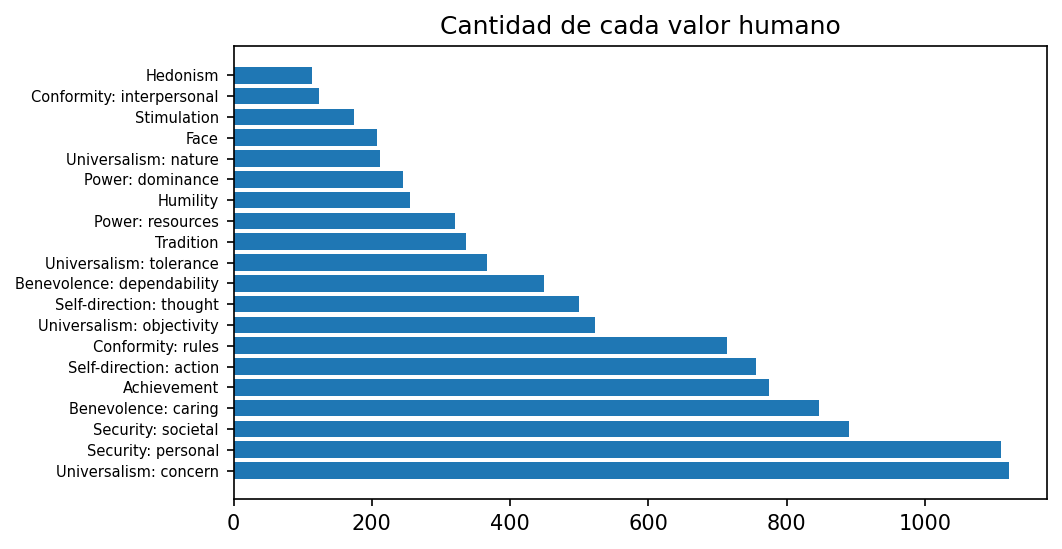

In [ ]:
classesCount = y_train.sum().sort_values(ascending=False)
plt.figure(dpi=150,figsize=(7,4))
plt.barh(classesCount.index, classesCount.tolist())
plt.title("Cantidad de cada valor humano")
plt.yticks(size=7)

In [ ]:
stopwordsEn = set(stopwords.words("english"))
vectorizer = TfidfVectorizer(lowercase=True, max_features=5000)
vectorizer.fit(X_train.Conclusion)
ConclusionWords = ["Conclusion-"+w.capitalize() for w in vectorizer.get_feature_names_out()]

for df in [X_train, X_val, X_test]:
    wordMatrix = vectorizer.transform(df.Conclusion)
    df[ConclusionWords] = pd.DataFrame(wordMatrix.todense(), columns=ConclusionWords, index=df.index)
    for c in ConclusionWords:
        df[c] = df["Stance"]*df[c]

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3641: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[k1] = value[k2]


In [ ]:
xFts = ConclusionWords

In [ ]:
from sklearn.decomposition import PCA

reducer1 = PCA(n_components=100)

redConclusion = ["ConclusionR"+str(i+1) for i in range(100)]

reducer1.fit(df[ConclusionWords])

for df in [X_train, X_val, X_test]:
    df[redConclusion] = reducer1.transform(df[ConclusionWords])

xFts = redConclusion

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at o

In [ ]:
scaler = StandardScaler()

scaler.fit(X_train[xFts])

for df in [X_train, X_val, X_test]:
    df[xFts] = scaler.transform(df[xFts])

#**BASELINE BETA (LOGREG)**

In [ ]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
lrModel = LogisticRegression(random_state=420)
multilabelModel = MultiOutputClassifier(lrModel)
multilabelModel.fit(X_train[xFts],y_train)
multilabelModel.score(X_val[xFts],y_val)

In [ ]:
hpar_space = [
    {
        "estimator": [lrModel],
        "estimator__solver": ["newton-cg","liblinear","lbfgs","sag","saga"],
        "estimator__penalty": ["l1","l2","none"],
        "estimator__C": [0.1, 1, 10, 100, 1000]
    }
]

search = RandomizedSearchCV(multilabelModel, hpar_space, cv=3, n_iter=12, scoring='accuracy', verbose=10, random_state=420)
result = search.fit(X_train[xFts], y_train)

In [ ]:
# multilabelModel = result

In [ ]:
# multilabelModel.score(X_val[xFts],y_val)

#**BASELINE (SVM)**

In [ ]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
svcModel = SVC(random_state=420)
multilabelModel = MultiOutputClassifier(svcModel)
multilabelModel.fit(X_train[xFts],y_train)
print("Score de validación del modelo SVC: " + str(multilabelModel.score(X_val[xFts],y_val)))

Score de validación del modelo SVC: 0.07763023493360573


In [ ]:
hpar_space = [
    {
        "estimator": [svcModel],
        "estimator__kernel": ['rbf'],
        "estimator__gamma": [1, 0.1, 0.01, 0.001, 0.0001],
        "estimator__C": [1000, 100, 10, 1, 0.1],
        "estimator__degree": [1,2,3,4,5,6]
    }
]

search = RandomizedSearchCV(multilabelModel, hpar_space, cv=5, n_iter=20, scoring='f1_macro', verbose=10, random_state=420)
result = search.fit(X_train[xFts], y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5; 1/20] START estimator=SVC(random_state=420), estimator__C=10, estimator__degree=2, estimator__gamma=0.1, estimator__kernel=rbf
[CV 1/5; 1/20] END estimator=SVC(random_state=420), estimator__C=10, estimator__degree=2, estimator__gamma=0.1, estimator__kernel=rbf;, score=0.414 total time=   3.0s
[CV 2/5; 1/20] START estimator=SVC(random_state=420), estimator__C=10, estimator__degree=2, estimator__gamma=0.1, estimator__kernel=rbf
[CV 2/5; 1/20] END estimator=SVC(random_state=420), estimator__C=10, estimator__degree=2, estimator__gamma=0.1, estimator__kernel=rbf;, score=0.395 total time=   2.9s
[CV 3/5; 1/20] START estimator=SVC(random_state=420), estimator__C=10, estimator__degree=2, estimator__gamma=0.1, estimator__kernel=rbf
[CV 3/5; 1/20] END estimator=SVC(random_state=420), estimator__C=10, estimator__degree=2, estimator__gamma=0.1, estimator__kernel=rbf;, score=0.415 total time=   2.9s
[CV 4/5; 1/20] START estimato

In [ ]:
print("F1 Score de validación del modelo SVC tuneado: " + str(result.score(X_val[xFts],y_val)))

In [ ]:
preds = result.predict(X_val[xFts])

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5]),
 <a list of 21 Text major ticklabel objects>)

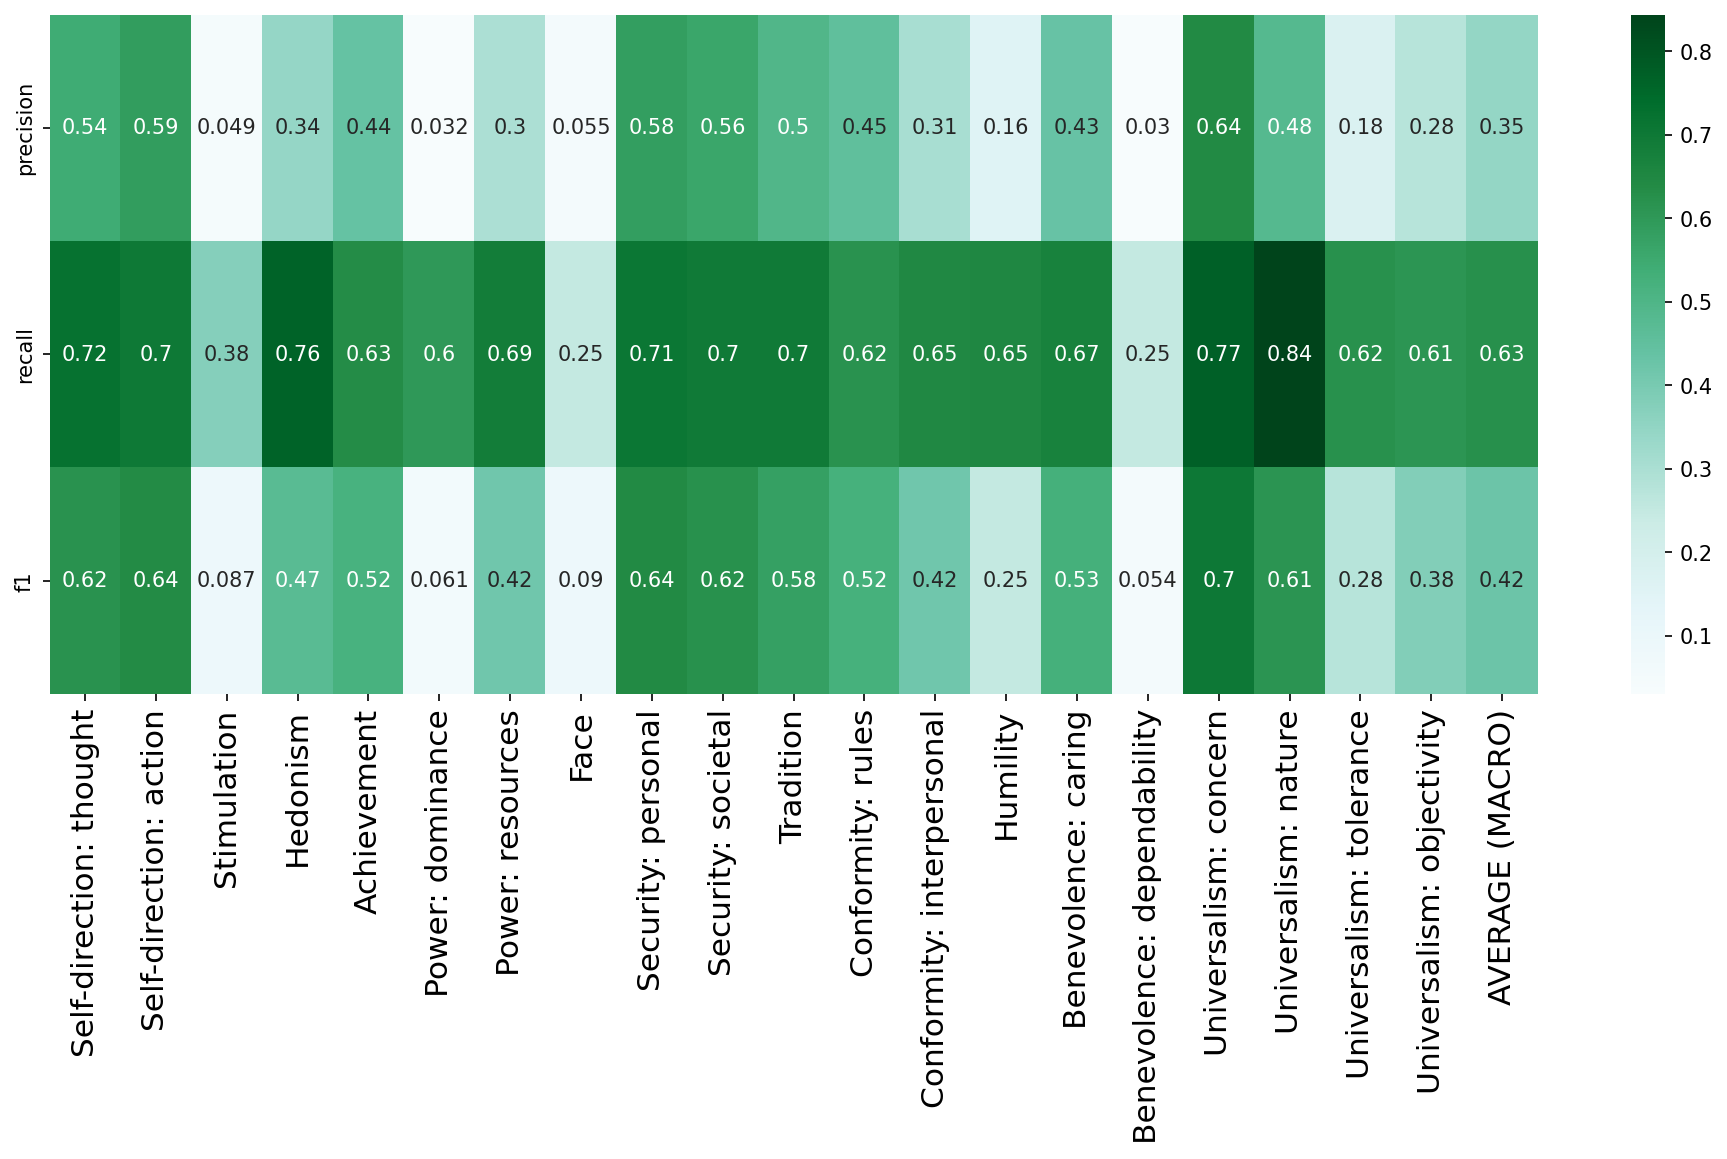

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

predDf= pd.DataFrame(preds, columns=y_train.columns)
prfDf = pd.DataFrame(precision_recall_fscore_support(predDf, y_val)[:3], index=["precision","recall","f1"], columns=y_train.columns)
prfDf["AVERAGE (MACRO)"] = precision_recall_fscore_support(predDf, y_val, average="macro")[:3]


plt.figure(dpi=150, figsize=(16,6))
sns.heatmap(prfDf, cmap="BuGn", annot=True)
plt.xticks(size=15)